In [1]:
# Set up
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Gathering the data

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [3]:
# getting aggregated legacy view data for desktop
legacy_desktop = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2016070100"
                    }

# getting aggregated legacy view data for mobile
legacy_mobile = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2016070100"
                    }

# getting aggregated current standard pageview data for desktop
pageviews_desktop = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2020090100'
                        }

# getting aggregated current standard pageview data for mobile web
pageviews_mobile_web = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2020090100'
                        }


# getting aggregated current standard pageview data for mobile app
pageviews_mobile_app = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2020090100'
                        }


headers = {
    'User-Agent': 'https://github.com/Shuya-Ma',
    'From': 'shuyama@uw.edu'
}

In [4]:
# get json file
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [5]:
# write to json file
def write_json(filename, data):
    with open(filename, 'w') as f:
        json.dump(data, f)

In [6]:
write_json('pagecounts_desktop_200712-201607.json', api_call(endpoint_legacy, legacy_desktop))

write_json('pagecounts_mobile_200712-201607.json', api_call(endpoint_legacy, legacy_mobile))

write_json('pageviews_desktop_201507-202010.json', api_call(endpoint_pageviews, pageviews_desktop))

write_json('pageviews_mobile_web_201507-202010.json', api_call(endpoint_pageviews, pageviews_mobile_web))

write_json('pageviews_mobile_app_201507-202010.json', api_call(endpoint_pageviews, pageviews_mobile_app))

In [7]:
def read_json_2df(filename):
    with open(filename) as f:
        data = json.load(f)
    return pd.DataFrame(data['items'])

In [8]:
# read data from json file

pagecounts_desktop_monthly = read_json_2df('pagecounts_desktop_200712-201607.json')

pagecounts_mobile_monthly = read_json_2df('pagecounts_mobile_200712-201607.json')

pageviews_desktop_monthly = read_json_2df('pageviews_desktop_201507-202010.json')

pageviews_mobile_web_monthly = read_json_2df('pageviews_mobile_web_201507-202010.json')

pageviews_mobile_app_monthly = read_json_2df('pageviews_mobile_app_201507-202010.json')


# Step 2: Processing the data

In [9]:
# combine the monthly values for mobile-app and mobile-web for Pageviews, and only keep timestamp and pageview_mobile_view variable
pageviews_mobile_monthly = pageviews_mobile_web_monthly.merge(pageviews_mobile_app_monthly, left_on='timestamp', right_on='timestamp', how='outer',suffixes=('_web', '_app'))
pageviews_mobile_monthly['pageview_mobile_views'] = pageviews_mobile_monthly['views_web'] + pageviews_mobile_monthly['views_app']
pageviews_mobile_monthly = pageviews_mobile_monthly[['timestamp', 'pageview_mobile_views']]

In [10]:
pagecounts_desktop_monthly['pagecount_desktop_views'] = pagecounts_desktop_monthly['count']
pagecounts_desktop_monthly =  pagecounts_desktop_monthly[['timestamp', 'pagecount_desktop_views']]

pagecounts_mobile_monthly['pagecount_mobile_views'] = pagecounts_mobile_monthly['count']
pagecounts_mobile_monthly =  pagecounts_mobile_monthly[['timestamp', 'pagecount_mobile_views']]

pageviews_desktop_monthly['pageview_desktop_views'] = pageviews_desktop_monthly['views']
pageviews_desktop_monthly =  pageviews_desktop_monthly[['timestamp', 'pageview_desktop_views']]

In [11]:
# combine all data to one data frame
all_data = pagecounts_desktop_monthly.merge(pagecounts_mobile_monthly, left_on='timestamp', right_on='timestamp', how='outer')
all_data = all_data.merge(pageviews_desktop_monthly, left_on='timestamp', right_on='timestamp', how='outer')
all_data = all_data.merge(pageviews_mobile_monthly, left_on='timestamp', right_on='timestamp', how='outer')

In [12]:
# fill NA/NaN with 0 
all_data = all_data.fillna(0)

# calculate pagecount_all_views and pageview_all_views
all_data['pagecount_all_views'] = all_data['pagecount_desktop_views'] + all_data['pagecount_mobile_views']
all_data['pageview_all_views'] = all_data['pageview_desktop_views'] + all_data['pageview_mobile_views']

In [13]:
# separate the value of timestamp year and month 
def modify_time(df):
    df['year'] = df['timestamp'].apply(lambda x: x[:4])
    df['month'] = df['timestamp'].apply(lambda x: x[4:6])
    df = df.drop('timestamp', axis=1)
    return df

In [14]:
# modify time format
all_data = modify_time(all_data)

# re-order the columns in data frame
all_data = all_data[['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]

In [15]:
# save all data to a CSV file
all_data.to_csv('en-wikipedia_traffic_200712-202008.csv', index=False)

# Step 3: Analyze the data

### Ploting Preparation

In [16]:
# change 0 back to NaN for ploting
all_data = all_data.replace(0, np.nan)

# set a DateTime index for ploting
all_data.set_index(pd.to_datetime({
    'day': 1,
    'month': all_data.pop('month'),
    'year': all_data.pop('year')
}), inplace=True)

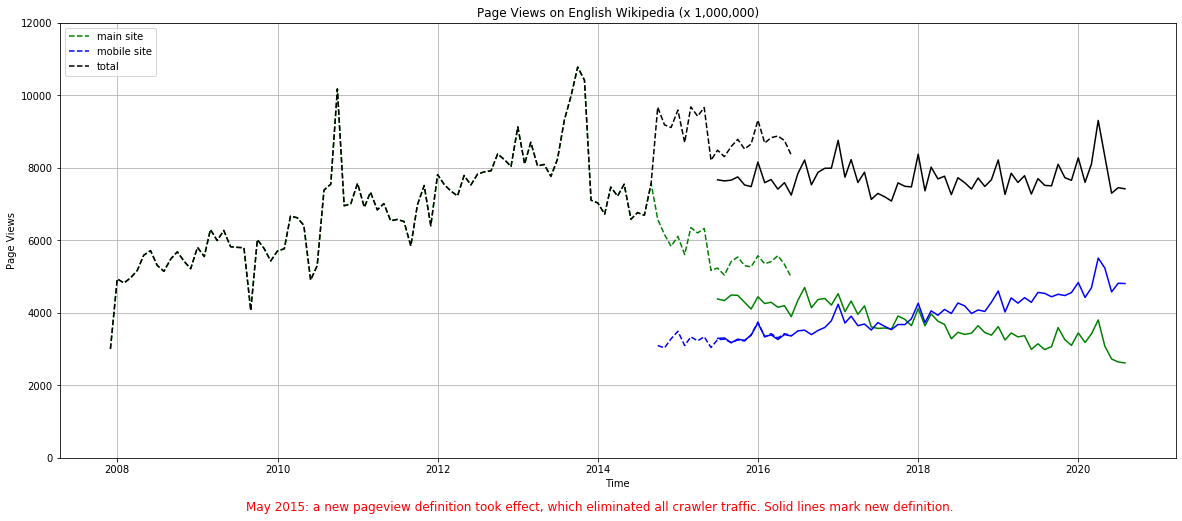

In [30]:
fig = plt.figure(figsize=(20,8))
plt.plot(all_data['pagecount_desktop_views']/1000000,'g--', label='main site')
plt.plot(all_data['pagecount_mobile_views']/1000000, 'b--', label='mobile site')
plt.plot(all_data['pagecount_all_views']/1000000, 'k--', label='total')
plt.plot(all_data['pageview_desktop_views']/1000000, 'g-')
plt.plot(all_data['pageview_mobile_views']/1000000, 'b-')
plt.plot(all_data['pageview_all_views']/1000000, 'k-')
plt.xlabel('Time')
plt.ylabel('Page Views')
plt.title('Page Views on English Wikipedia (x 1,000,000)')
plt.suptitle('May 2015: a new pageview definition took effect, which eliminated all crawler traffic. Solid lines mark new definition.', y=0.05, color ='r')
plt.ylim(0, 12000)
plt.legend(loc=2)
plt.grid()
plt.show()
fig.savefig('pagevies_plot.png')